# Predição de Preço de Lares



In [87]:
# Modules

# General functionality and file manipulation
import os
from datetime import datetime

# Data Processing
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Confusion matrix
from sklearn.metrics import confusion_matrix

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

# Objective

É uma competição Kaagle no qual nosso objetivo será prever os preços das moradias utilizando redes neurais. Em especial, para cada "id" queremos prever o "SalePrice" na base de teste, baseado no modelo treinado na base de treino.

# Metric

Os envios são avaliados com base no erro quadrático médio (RMSE) entre o logaritmo do valor previsto e o logaritmo do preço de venda observado.

sum( ( log(y_i) - log(y^hat_i) )^2 )_{i=0}^{n}

# Data Reading and Wrangling

In [88]:
train = pd.read_csv('data/train.csv')
display(train.head())
print(f"Dim:\n{train.shape}")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Dim:
(1460, 81)


Useless columns that have much NA's. We will drop them.

Also, we will be dropping 'id'.

In [89]:
display(train.isna().mean()[train.isna().mean() > 0.3])

Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [90]:
useless_cols = train.isna().mean()[train.isna().mean() > 0.3].index.tolist()
useless_cols.append('Id')
train.drop(columns=useless_cols, inplace=True)

# EDA

In [91]:
df = train

## Studying SalePrice

In [92]:
print(f"NA Count: {df['SalePrice'].isna().mean()}")

NA Count: 0.0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
/home/adriel_martins/Documents/Adriel_ET645/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

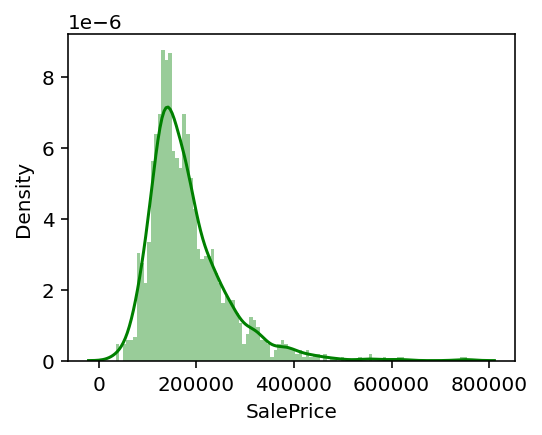

In [93]:
print(df['SalePrice'].describe())
plt.figure(figsize=(4, 3))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})

## Numerical Explanatory Variables

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

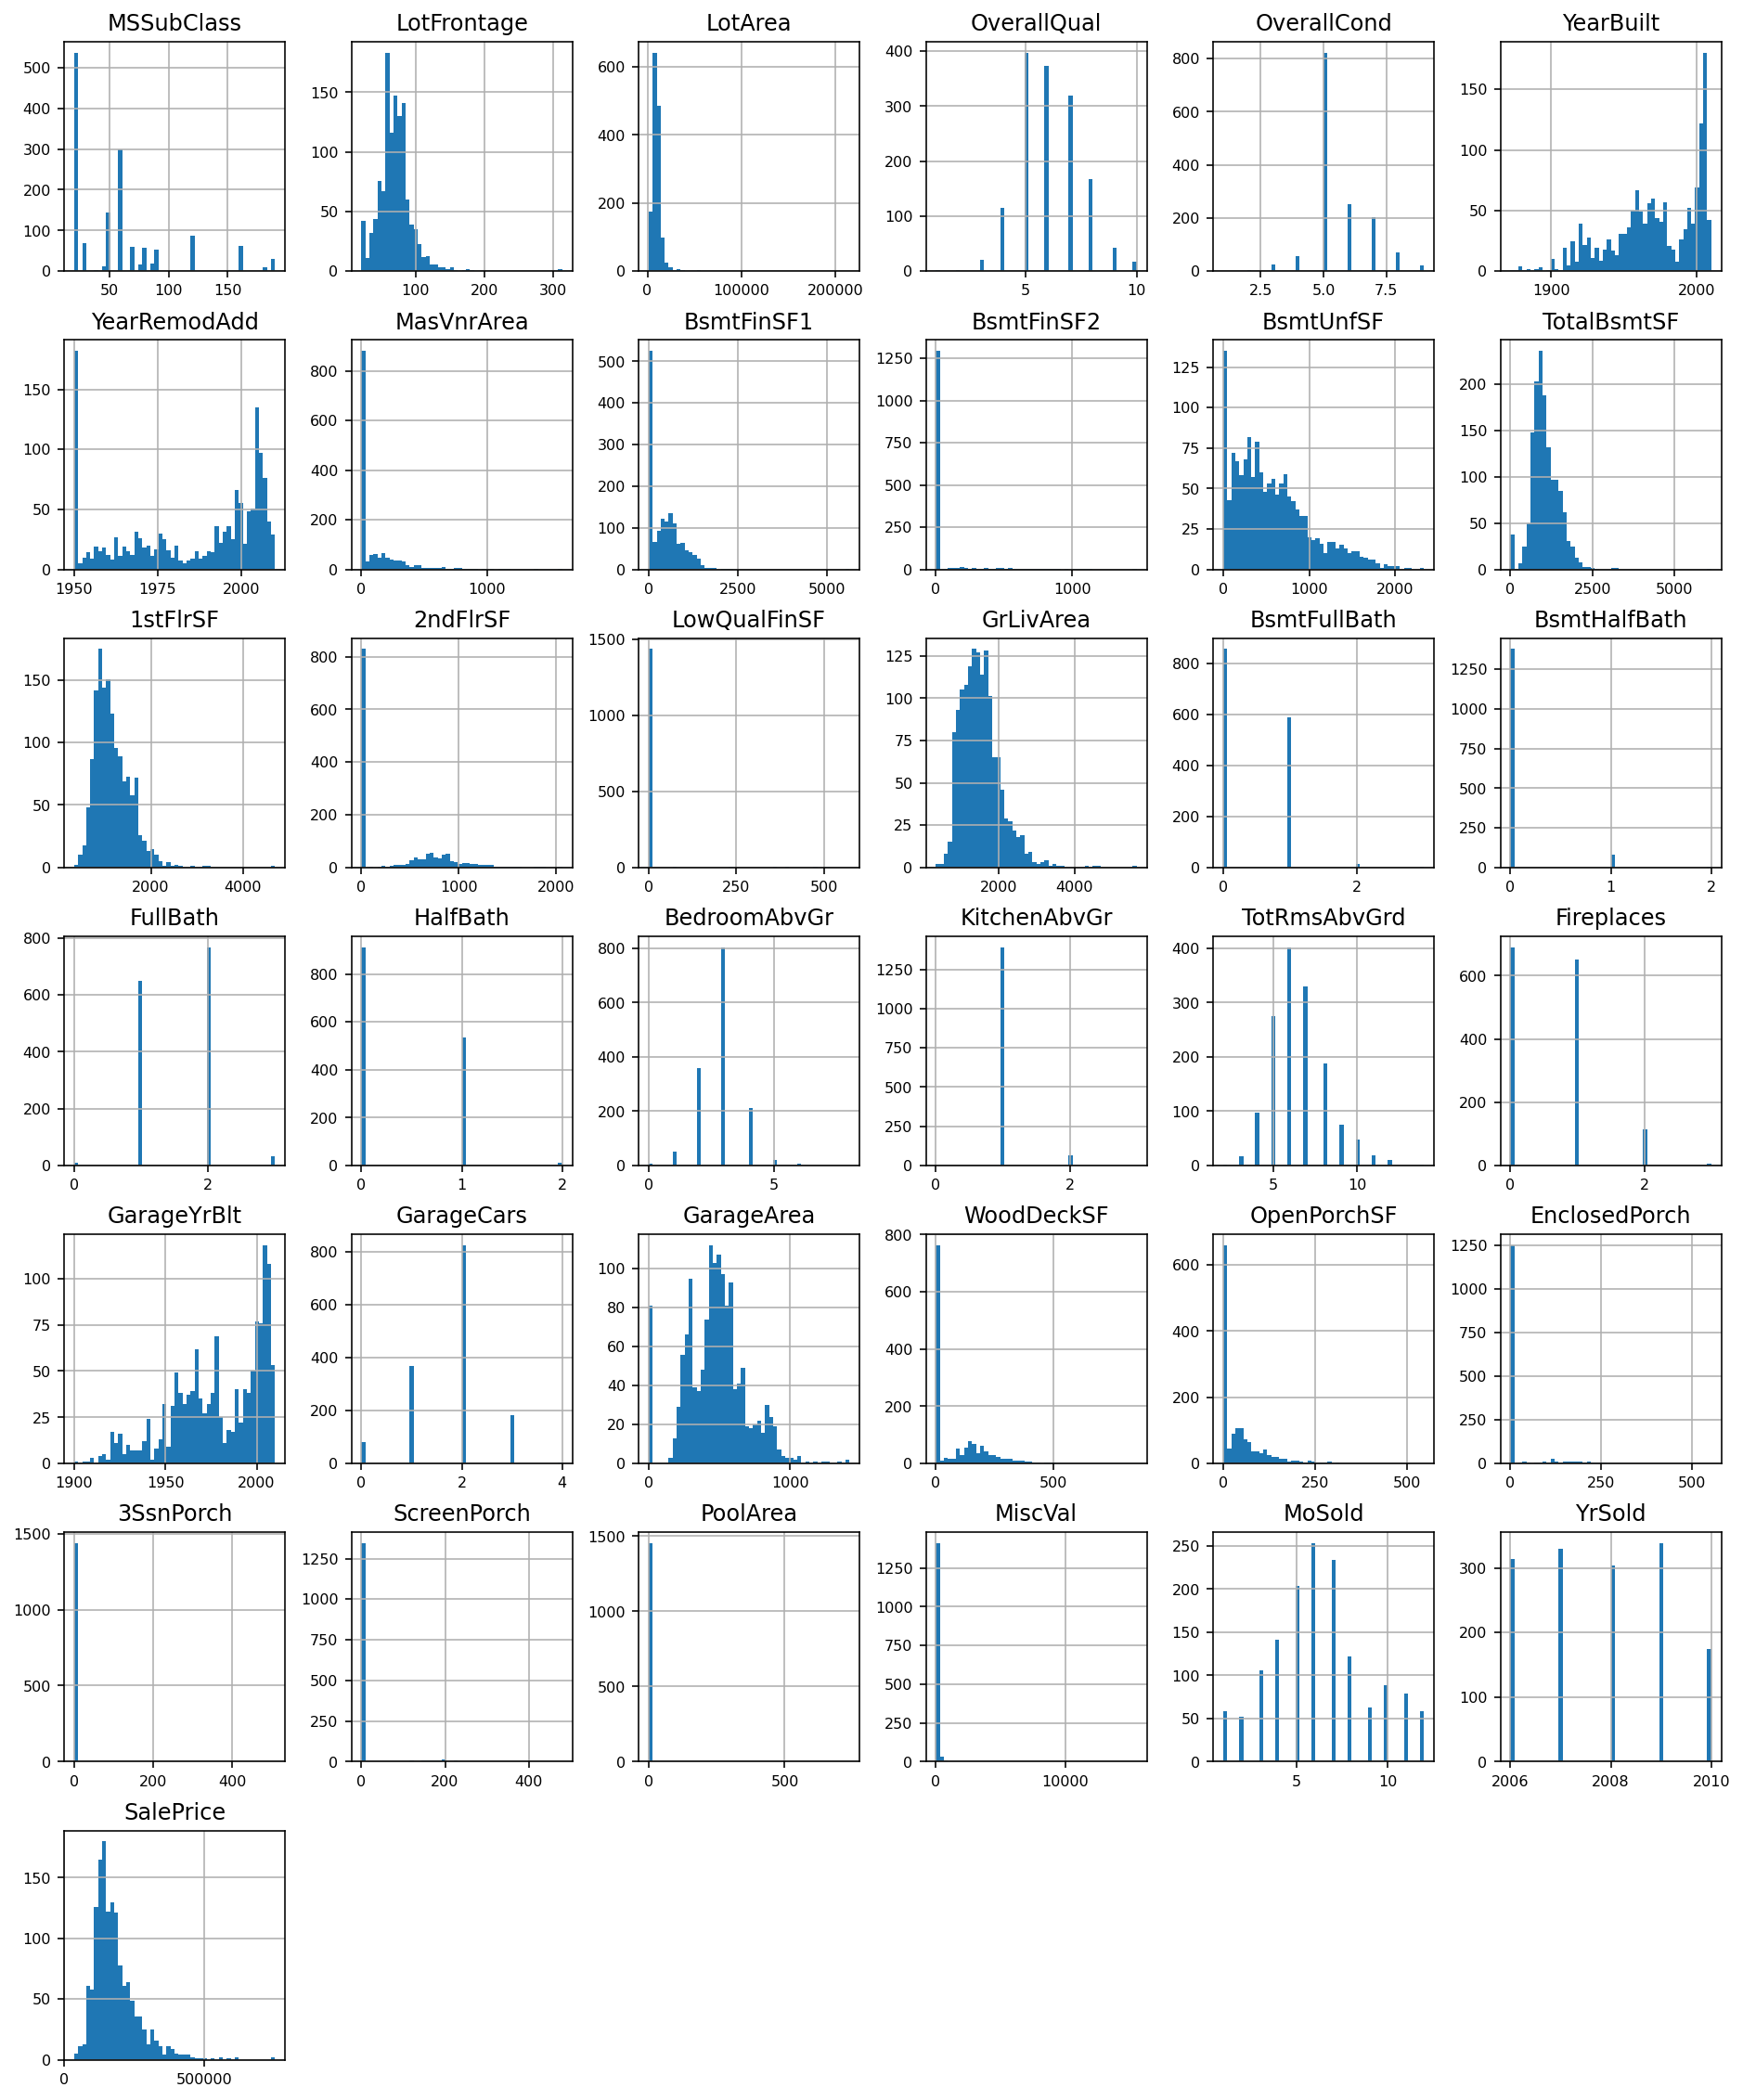

In [94]:
df.select_dtypes(include = ['float64', 'int64']).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### Linear Correlation of Numerical Variables with SalePrice

In [95]:
df_num_corr = df.select_dtypes(include = ['float64', 'int64']).corr()['SalePrice'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 10 strongly correlated values with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


### Non Linear Correlation with SalePrice

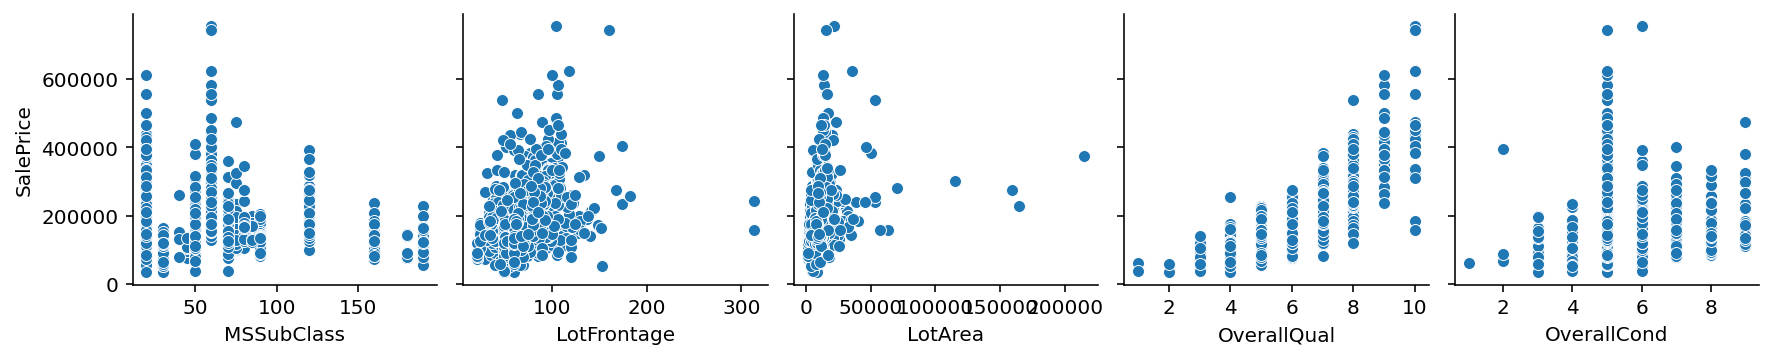

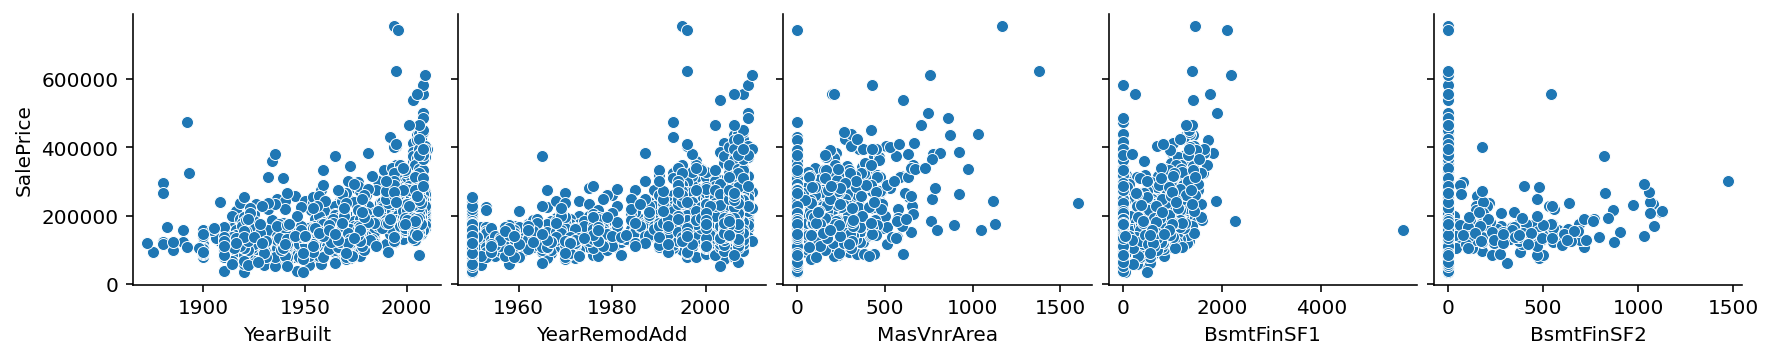

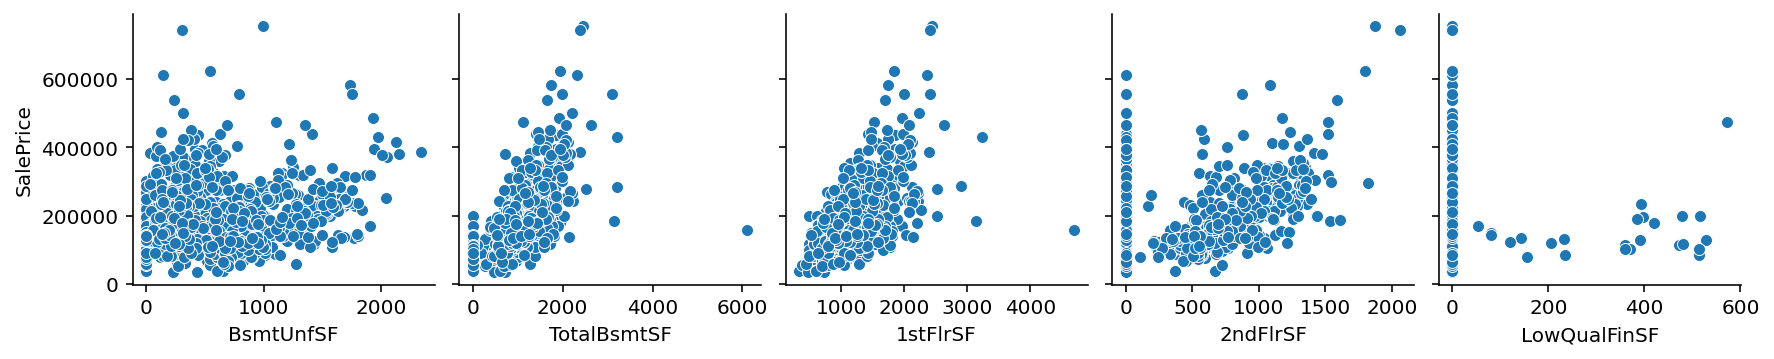

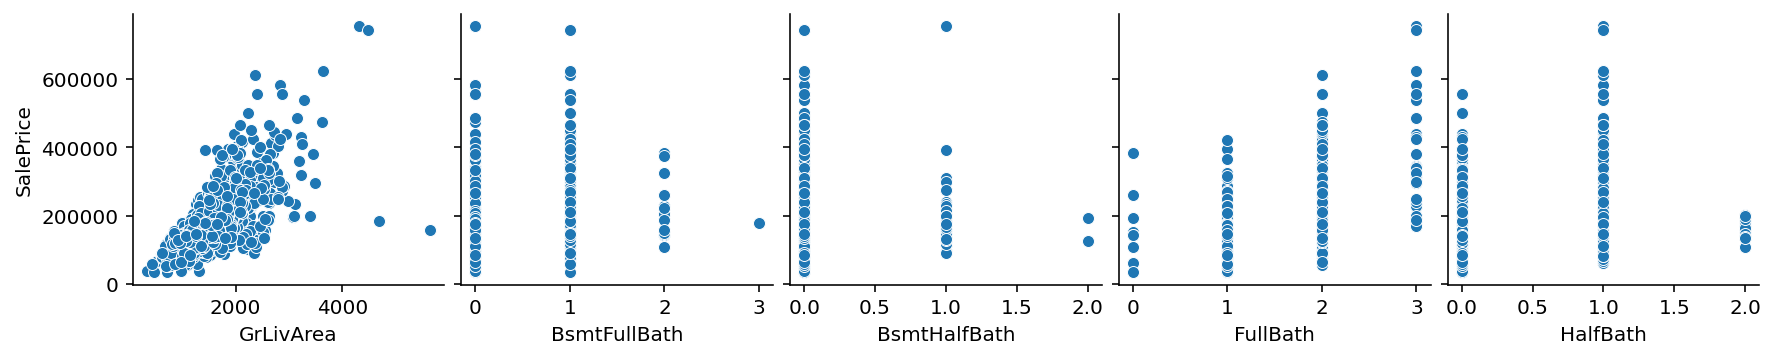

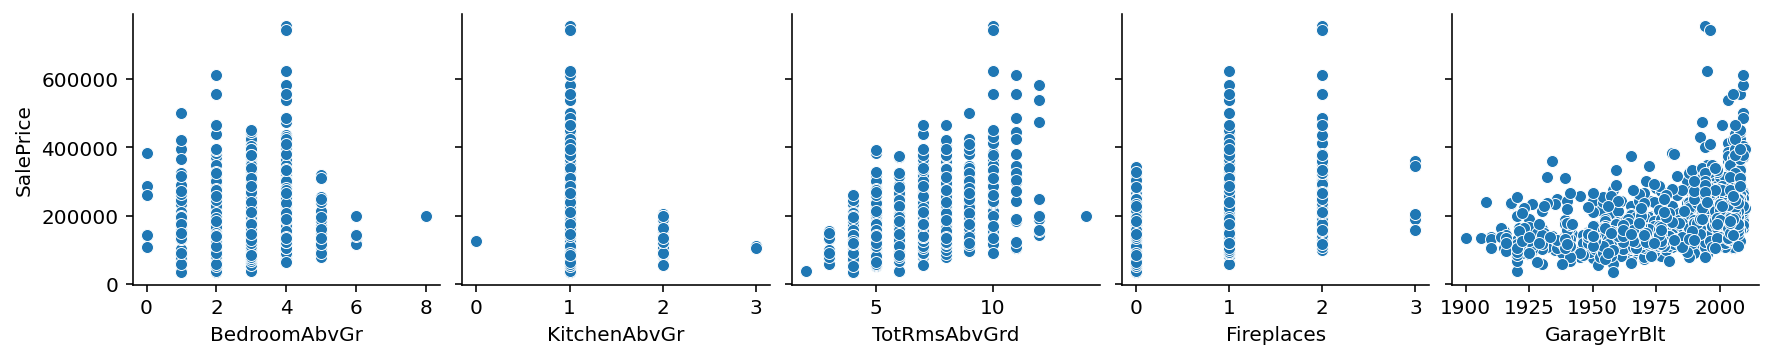

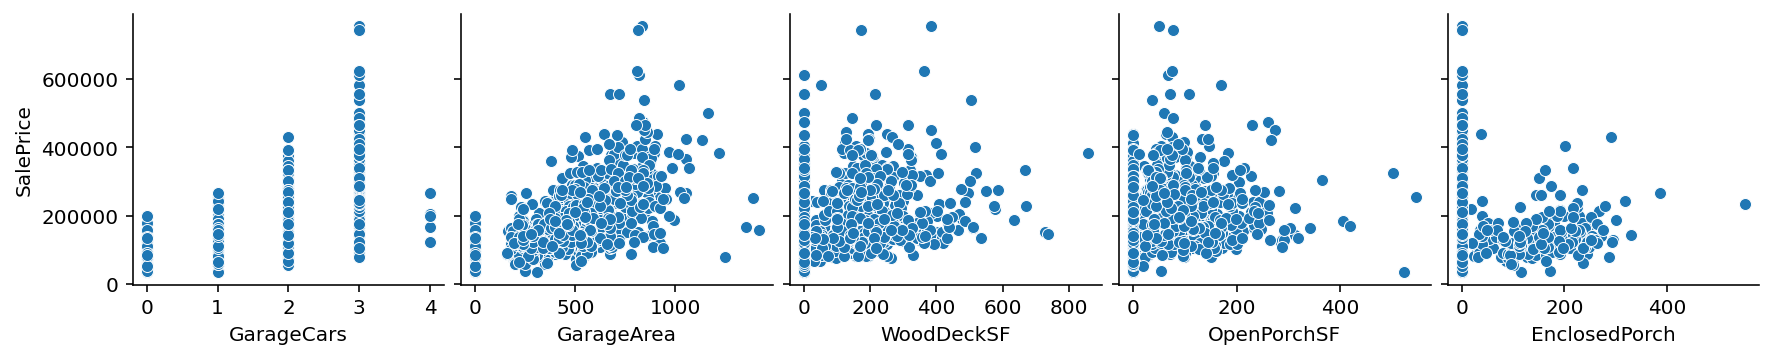

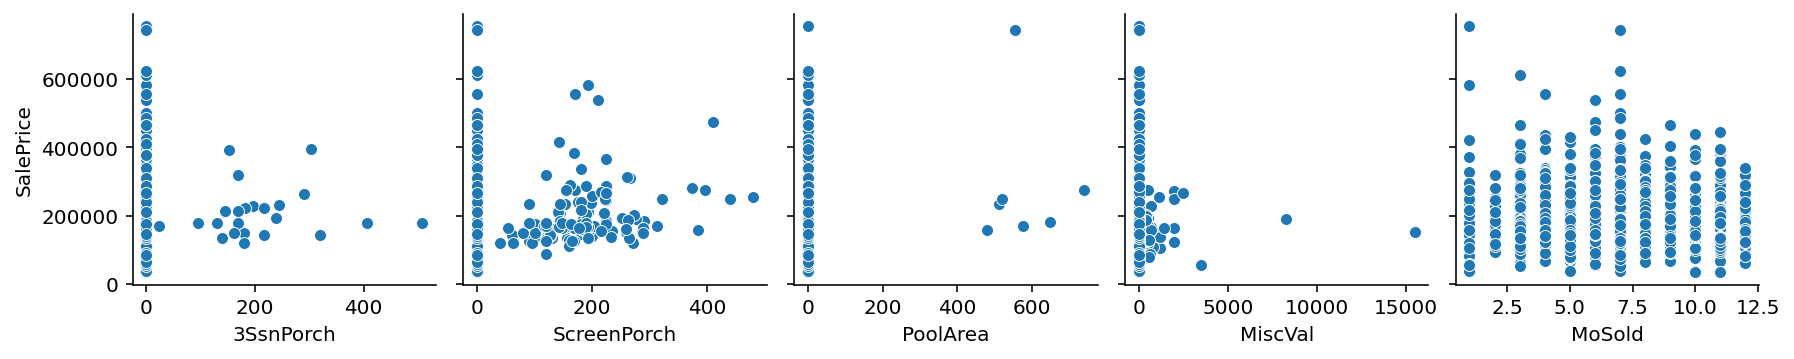

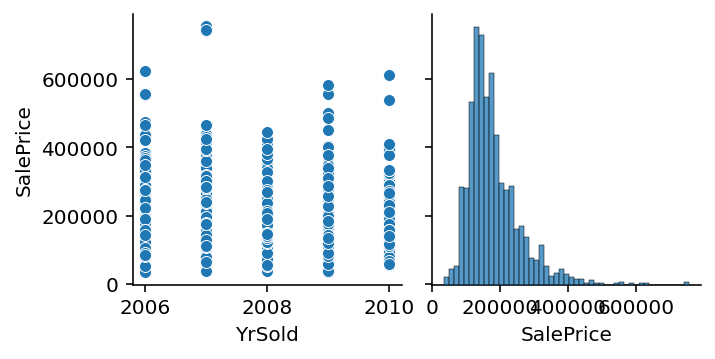

In [96]:
for i in range(0, len(df.select_dtypes(include = ['float64', 'int64']).columns), 5):
    sns.pairplot(data=df.select_dtypes(include = ['float64', 'int64']),
                x_vars=df.select_dtypes(include = ['float64', 'int64']).columns[i:i+5],
                y_vars=['SalePrice'])

### Correlations between all variables

<AxesSubplot:>

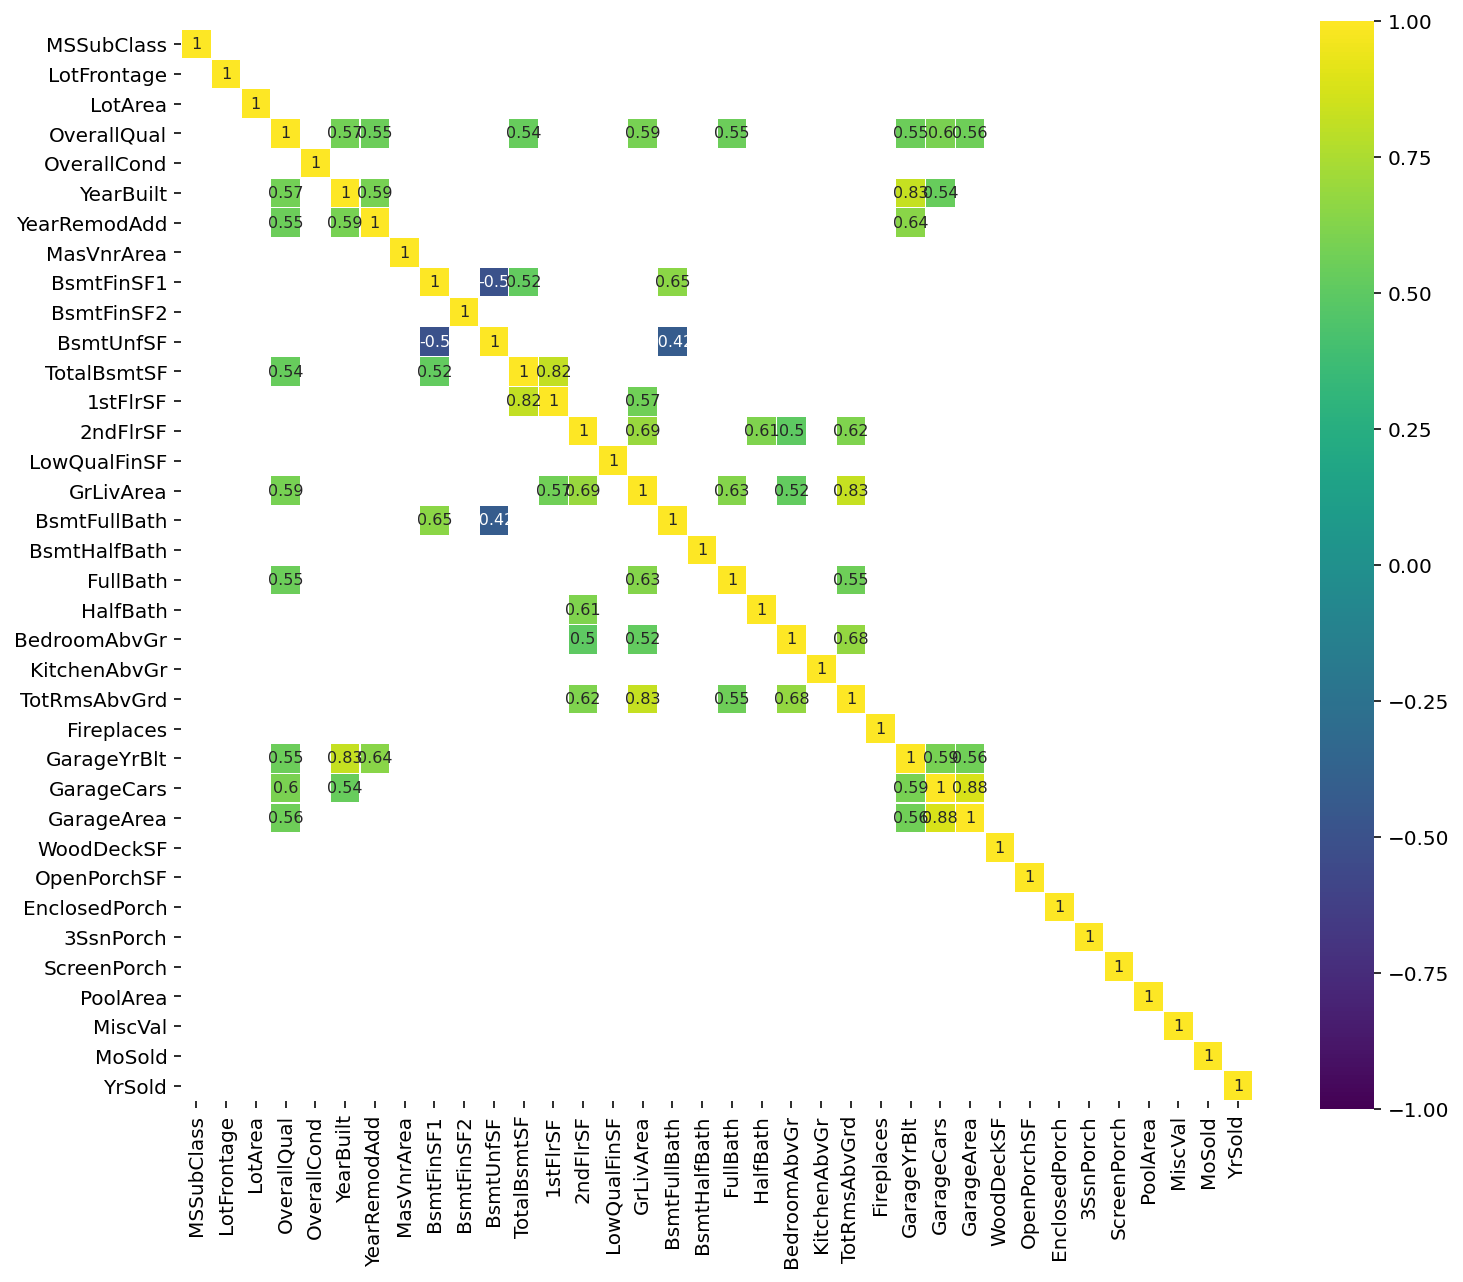

In [97]:
corr = df.select_dtypes(include = ['float64', 'int64']).drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

### Analyzing the strong linear correlations.

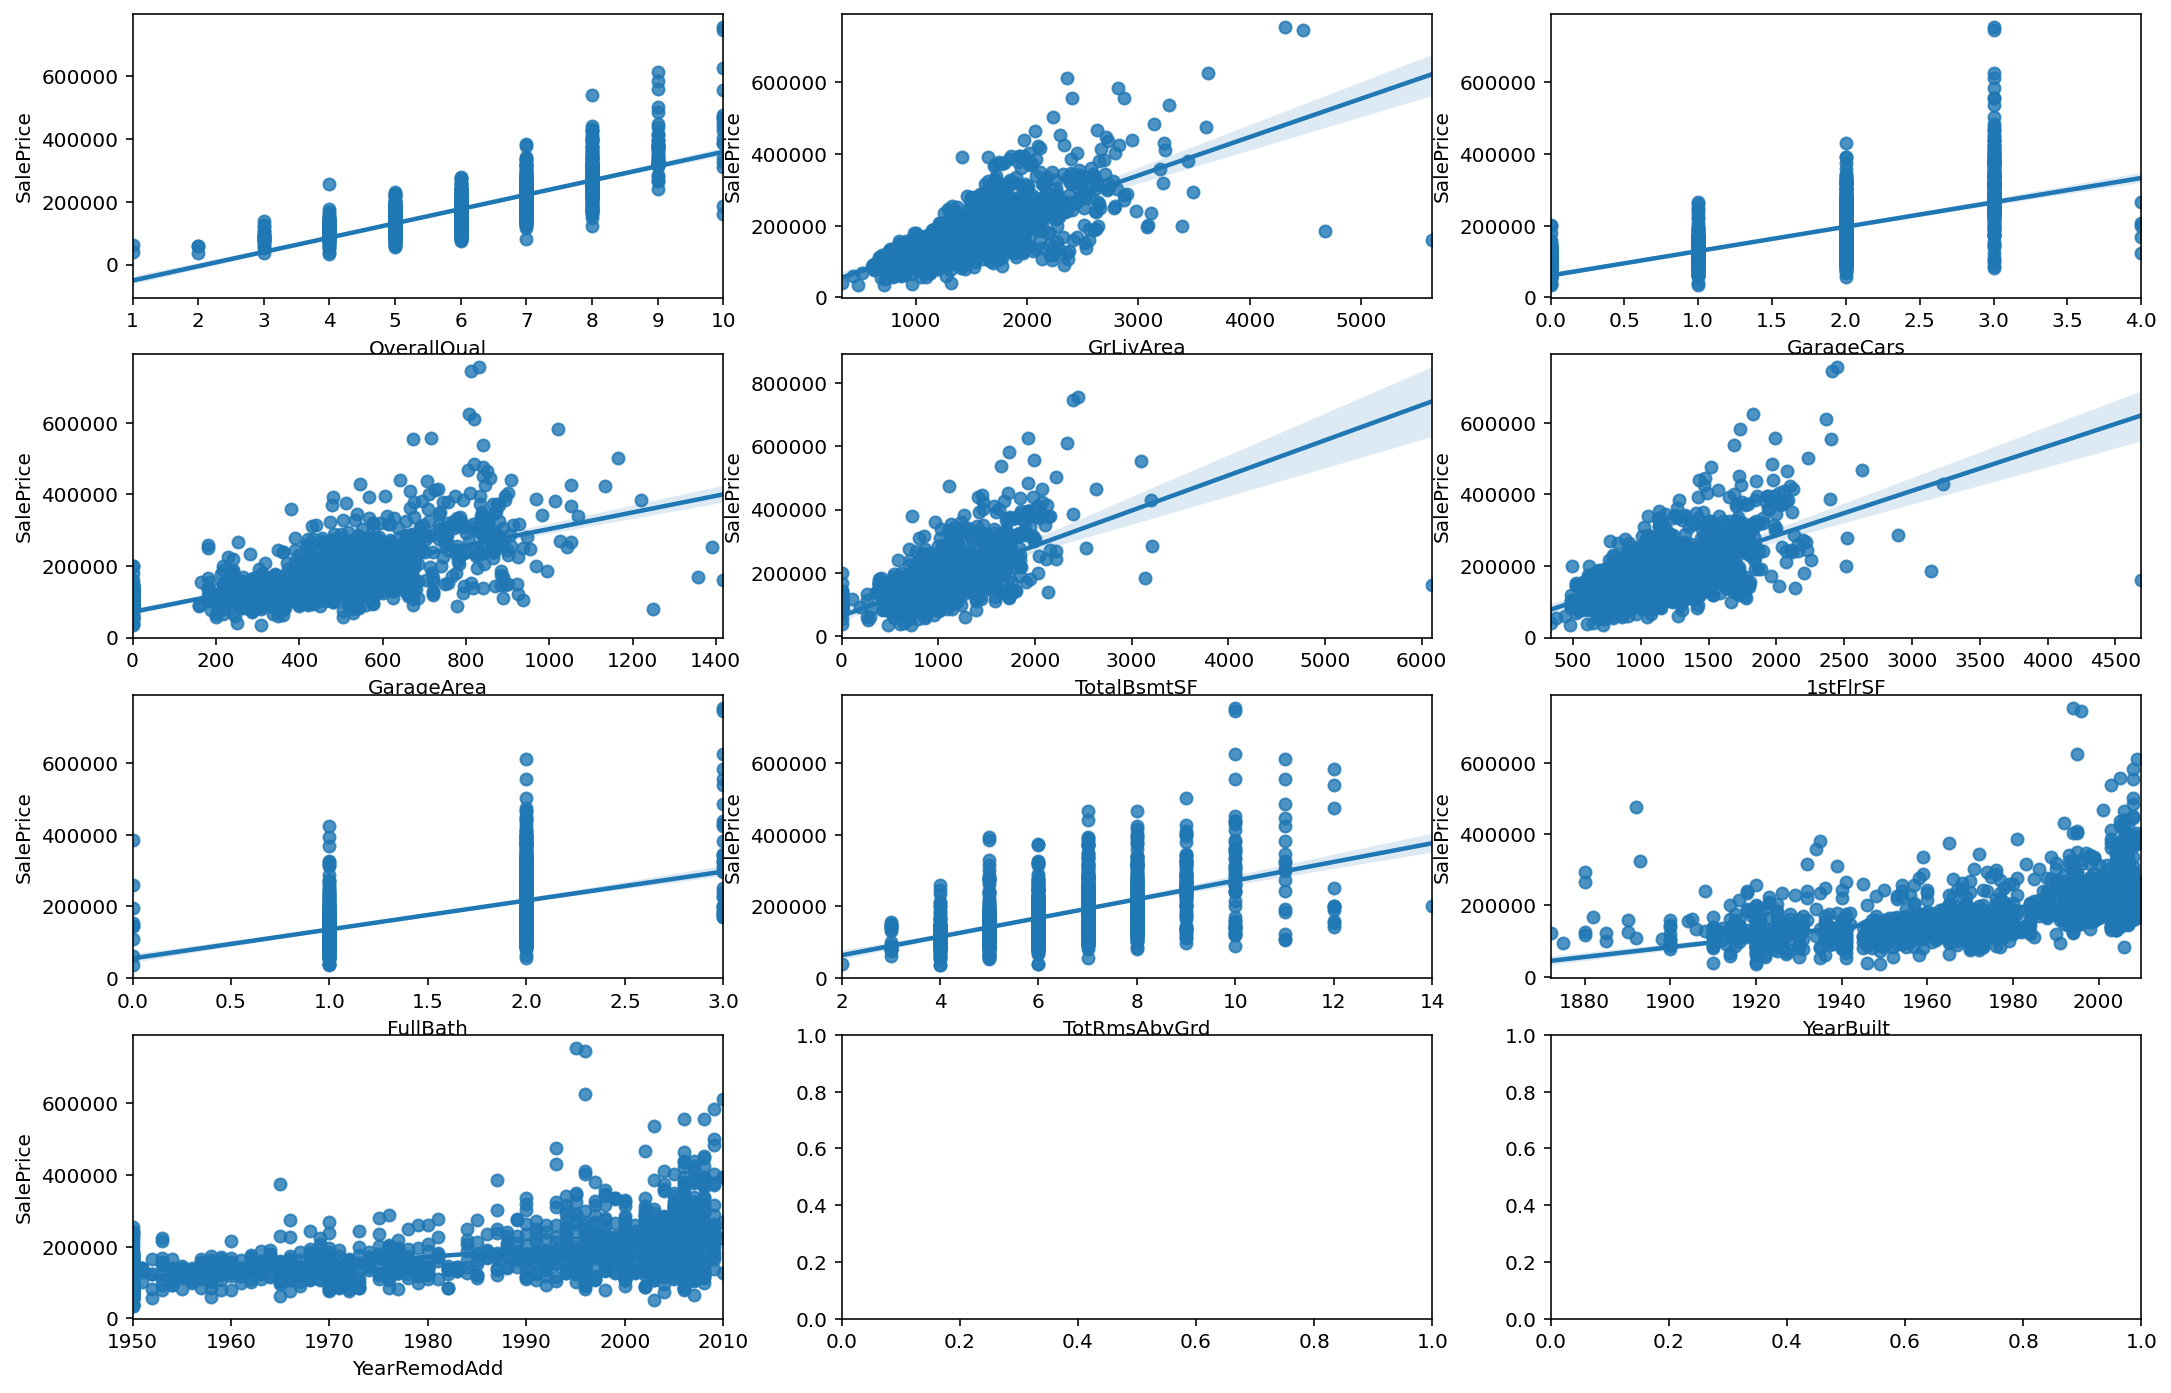

In [98]:
features_to_analyse = golden_features_list.index.to_list()
features_to_analyse.append('SalePrice')
features_to_analyse = np.array(features_to_analyse)

fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='SalePrice', data=df[features_to_analyse], ax=ax)

# Data Wrangling

## Preprocess

In [99]:
def preprocess(df, transformers:dict={}, data_type='train'):
    """
    Preprocess the dataframe to better use in the model.

    Args:
        df (pd.DataFrame)
        transformers (dict, optional): Dictionary of transformers. Defaults to {}.

    Returns:
        [pd.DataFrame]
        [dict]: Dictionary of transformers used. 
    """
    df_wrangling = df.copy()

    if data_type == 'test':
        id_series = df_wrangling['Id']
    else:
        id_series = None

    # One Hot Enconding
    categorical_variables = df_wrangling.select_dtypes(exclude = ['float64', 'int64'])
    try:
        enc = transformers['encoder']
    except:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(categorical_variables)
    
    df1 = enc.transform(categorical_variables).toarray()
    df1 = pd.DataFrame(df1, columns=enc.get_feature_names(categorical_variables.columns.tolist()))
    df2 = df_wrangling.drop(columns=categorical_variables.columns)
    df_wrangling = pd.concat([df1, df2], axis=1)

    # Scaling 
    try:
        scaler = transformers['scaler']
        if not 'label' in df_wrangling.columns:
            df_wrangling['label'] = np.repeat(0, len(df_wrangling))
    except:
        scaler = MinMaxScaler()
        scaler.fit(df_wrangling)

    df_wrangling = pd.DataFrame(scaler.transform(df_wrangling),
                                columns=df_wrangling.columns)
    if ((df_wrangling['label'] == 0).mean() == 1):
        df_wrangling.drop(columns='label', inplace=True)

    # Dropping useless columns
    try:
        useless_cols = transformers['cols_to_drop']
    except:
        useless_cols = df_wrangling.isna().mean()[df_wrangling.isna().mean() > 0.3].index.tolist()
        useless_cols.append('Id')

    df_wrangling.drop(columns=useless_cols, inplace=True)

    if data_type== 'test':
        df_wrangling['label'] = id_series

    # Dropping NA's
    df_wrangling.dropna(inplace=True)

    return df_wrangling, {'scaler': scaler,
                          'encoder': enc,
                          'cols_to_drop': useless_cols,
                          'test_id_series': id_series}

## Dataloader and Transformations

In [100]:
class DataRow(Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        self.predict_data = not ('label' in df.columns.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.df.iloc[idx]

        if self.predict_data:
            label = -1
            features = row.to_numpy()
        else:
            label = row['label']
            features = row.drop(labels='label').to_numpy()
            
        row = {'label': label, 'features': features}
        
        if self.transform:
            row = self.transform(row)
        
        return row 

In [101]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        label, features = sample['label'], sample['features']

        # If data is to be predicted.
        if label == -1:
            return {'label': label,
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

        return {'label': torch.from_numpy(np.array(label)).type(torch.FloatTensor),
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

In [102]:
def make_dataloader(df, batch_size):
    data = DataRow(df=df,
                   transform=transforms.Compose([ToTensor()]))
    dataloader = DataLoader(data, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    return dataloader

In [103]:
batch_size = 128
label_name = 'SalePrice'

df_train = pd.read_csv('data/train.csv').rename(columns={label_name: 'label'})
df_train, train_transformers = preprocess(df_train)

X_train, X_validation, y_train, y_validation = train_test_split(df_train[[col for col in df_train.columns if col != 'label']],
                                                                df_train['label'],
                                                                test_size = 0.1)

X_train['label'] = y_train
X_validation['label'] = y_validation

df_train = X_train
df_validation = X_validation


# cols = pd.read_csv('data/test.csv').isna().mean()[pd.read_csv('data/test.csv').isna().mean() > 0.3].index.tolist()
# df_test = pd.read_csv('data/test.csv').drop(columns=cols).dropna()
df_test, transformers = preprocess(pd.read_csv('data/test.csv'),
                                  transformers=train_transformers,
                                  data_type='test')

dataloader = {}
names = ['train', 'validation', 'test']
for idx, df in enumerate([df_train, df_validation, df_test]):
    dataloader.update({names[idx]: make_dataloader(df, batch_size)})

In [104]:
for data in iter(dataloader['test']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([2798., 2502., 1795., 2627., 1715., 1550., 2886., 2726., 2442., 2789.,
        2159., 2540., 2662., 1614., 1934., 2128., 2551., 2119., 2833., 2277.,
        1481., 1742., 2566., 2207., 2731., 2032., 2372., 1870., 1612., 2016.,
        1461., 2793., 2180., 2134., 2440., 2421., 2505., 1753., 1791., 1839.,
        2408., 2890., 1474., 1716., 2777., 1479., 2807., 2114., 2441., 1813.,
        2170., 1825., 1773., 2868., 2036., 2216., 2313., 2210., 2395., 1822.,
        1496., 1761., 2649., 2186., 1665., 2552., 2861., 2226., 2428., 2389.,
        2625., 2263., 2582., 2418., 2563., 2445., 1678., 1790., 1509., 2221.,
        1526., 2509., 1695., 1623., 1854., 2488., 2556., 2232., 2907., 1519.,
        2459., 2096., 2188., 1866., 2559., 1684., 2245., 2676., 2755., 2008.,
        2547., 2769., 1688., 2025., 2166., 2012., 2227., 2879., 1723., 1478.,
        2828., 1974., 2080., 2838., 1801., 1583., 2805., 2052., 1968., 2514.,
        1473., 1987., 1819., 2671., 2891., 2564., 1537

In [105]:
for data in iter(dataloader['train']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([0.1341, 0.1668, 0.0897, 0.1737, 0.3487, 0.2208, 0.1348, 0.1800, 0.3890,
        0.1265, 0.2639, 0.5431, 0.2277, 0.1460, 0.1314, 0.2182, 0.2029, 0.1529,
        0.2480, 0.1140, 0.3154, 0.2501, 0.3265, 0.1946, 0.1307, 0.2987, 0.1736,
        0.1251, 0.2682, 0.1966, 0.2425, 0.2229, 0.0701, 0.2004, 0.2330, 0.2459,
        0.3763, 0.5792, 0.0904, 0.1944, 0.1022, 0.1223, 0.2543, 0.0855, 0.1932,
        0.1932, 0.1321, 0.1489, 0.1397, 0.2730, 0.2869, 0.0751, 0.3057, 0.1928,
        0.2251, 0.0946, 0.2293, 0.1314, 0.3404, 0.1321, 0.1501, 0.3945, 0.1876,
        0.3502, 0.1042, 0.1695, 0.1279, 0.1915, 0.3126, 0.2964, 0.1730, 0.3126,
        0.2029, 0.3341, 0.1390, 0.2680, 0.3959, 0.1147, 0.1605, 0.2432, 0.1341,
        0.2626, 0.3820, 0.1939, 0.3279, 0.1446, 0.1321, 0.2015, 0.1321, 0.1222,
        0.1355, 0.2119, 0.1730, 0.1930, 0.1626, 0.0807, 0.1307, 0.4195, 0.1389,
        0.2327, 0.1251, 0.1494, 0.1432, 0.3195, 0.1918, 0.3959, 0.4167, 0.1737,
        0.2487, 0.1321, 0.3855

# Modelling

We will use the "linear regression" approach. We will model a neural net. that have no deep layer. There will only be input layer and output layer.

## Neural Network Architecture

In [106]:
class LinearRegression(nn.Module):
    def __init__(self, n_input, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_input, n_input * 2)
        self.fc2 = nn.Linear(n_input * 2, int(n_input/2))
        self.fc3 = nn.Linear(int(n_input/2), int(n_input/4))
        self.fc4 = nn.Linear(int(n_input/4), n_outputs)

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        return x.flatten()

## Trainning the model

In [107]:
def train_model(model, dataloader,
                criterion, optimizer,
                n_epoch=10, path_to_save='model.pt', 
                print_every=None):
    """
    Train our Neural Network with data and return the trained model,
    the plot diagnostics and also save the model in the path_to_save.
    
    Args:
    dataloader (dict): contains train dataloader and validation dataloader.
    path_to_save (str): path to save the model parameters in the .pt format.
    
    Returns:
    model: model trained with model.eval() = True.
    """
    # Checking if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cpu_or_gpu = ('GPU' if torch.cuda.is_available() else 'CPU')
    print(f"Running training on {cpu_or_gpu}")
    model = model.to(device)

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to +infinity

    train_losses = []
    valid_losses = []
    
    if print_every is None:
        print_every = int(n_epoch * 0.1) + 1
        
    for epoch in range(1, n_epoch + 1):
        
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # prep model for training
        model.train() 
        print('\n Training Loss...')
        turn = 0
        for data in dataloader['train']:

            x_train = data['features'].to(device)
            y_train = data['label'].to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_train) 
            # calculate the loss
            loss = criterion(output, y_train)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()
            
            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss}')


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        print("\n Validation Loss...")
        turn = 0
        for data in dataloader['validation']:
            x_validation = data['features'].to(device)
            y_validation = data['label'].to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_validation) # log_ps
            # calculate the loss
            loss = criterion(output, y_validation) 
            # update running validation loss 
            valid_loss += loss.item()

            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss} \n')

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(dataloader['train'])
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(dataloader['validation'])
        valid_losses.append(valid_loss)

        print(f"""
            Epoch: {epoch}
            \tTraining Loss: {round(train_loss, 6)}
            \tValidation Loss: {round(valid_loss, 6)}
            """)

        # save model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased \
                ({round(valid_loss_min,6)} --> {round(valid_loss,6)}).\
                    Saving model ...')
            torch.save(model.state_dict(), path_to_save)
            valid_loss_min = valid_loss
    
    # Plotting train and validation losses.
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    
    return model

Running training on GPU

 Training Loss...

 Validation Loss...

            Epoch: 1
            	Training Loss: 0.055571
            	Validation Loss: 0.069055
            
Validation loss decreased                 (inf --> 0.069055).                    Saving model ...

 Training Loss...

 Validation Loss...

            Epoch: 2
            	Training Loss: 0.055566
            	Validation Loss: 0.069055
            

 Training Loss...

 Validation Loss...

            Epoch: 3
            	Training Loss: 0.055478
            	Validation Loss: 0.069055
            

 Training Loss...

 Validation Loss...

            Epoch: 4
            	Training Loss: 0.055419
            	Validation Loss: 0.06902
            
Validation loss decreased                 (0.069055 --> 0.06902).                    Saving model ...

 Training Loss...

 Validation Loss...

            Epoch: 5
            	Training Loss: 0.051981
            	Validation Loss: 0.05787
            
Validation loss decreas

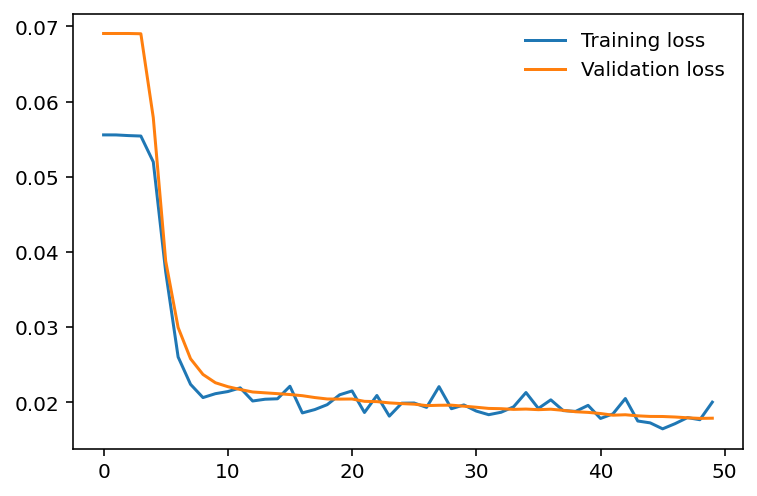

In [108]:
for data in iter(dataloader['train']):
    n_features = data['features'].shape[1]
    break
model = LinearRegression(n_input=n_features, n_outputs=1)

criterion = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model = train_model(model=model, n_epoch = 50,
                    dataloader=dataloader,criterion=criterion,
                    optimizer=optimizer, print_every=50)

In [109]:
# Reading the model parameters saved
for data in iter(dataloader['train']):
    n_features = data['features'].shape[1]
    break
mdel = LinearRegression(n_input=n_features, n_outputs=1)
model.load_state_dict(torch.load('model.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LinearRegression(
  (fc1): Linear(in_features=304, out_features=608, bias=True)
  (fc2): Linear(in_features=608, out_features=152, bias=True)
  (fc3): Linear(in_features=152, out_features=76, bias=True)
  (fc4): Linear(in_features=76, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Predict new dataset

In [110]:
def get_train_scaler():
    scaler_train = MinMaxScaler()
    df_train = pd.read_csv('data/train.csv').rename(columns={'SalePrice': 'label'})
    y_train = df_train['label'].values.copy()
    y_train.shape = (-1, 1)
    scaler_train.fit(y_train)
    return scaler_train

def scale_inverse(y_predicted, scaler):
    y_predicted = y_predicted.cpu().numpy()
    y_predicted.shape = (-1,1)
    return scaler.inverse_transform(y_predicted).flatten()

def predict(model, feat, scaler_train=get_train_scaler()):
    model.eval() # prepare model for evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # To speed up calculations, forget the gradients, etc.
    with torch.no_grad():
        x = data['features'].to(device)
        output = model(x)
        output = scale_inverse(output, scaler_train)
        return output


final_results = np.array(None)
id_results = np.array(None)
for data in iter(dataloader['test']):
    new_features = data['features']
    y_predicted = predict(model, new_features)
    final_results = np.append(final_results, y_predicted)

    id_results = np.append(id_results, data['label'].numpy())

final_results = np.array(final_results).flatten()[1:]
id_results = np.array(id_results).flatten()[1:]
df_results = pd.DataFrame.from_dict({'SalePrice': final_results, 'Id': id_results},
                                    orient='index').T
df_results.sort_values(by = 'Id')

,SalePrice,Id
270,137840.437500,1461.0
948,146768.453125,1462.0
694,164042.390625,1463.0
1037,171048.203125,1464.0
230,169196.531250,1465.0
...,...,...
459,151912.546875,2912.0
875,133079.328125,2913.0
717,132456.968750,2916.0
613,147025.875000,2917.0


/home/adriel_martins/Documents/Adriel_ET645/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

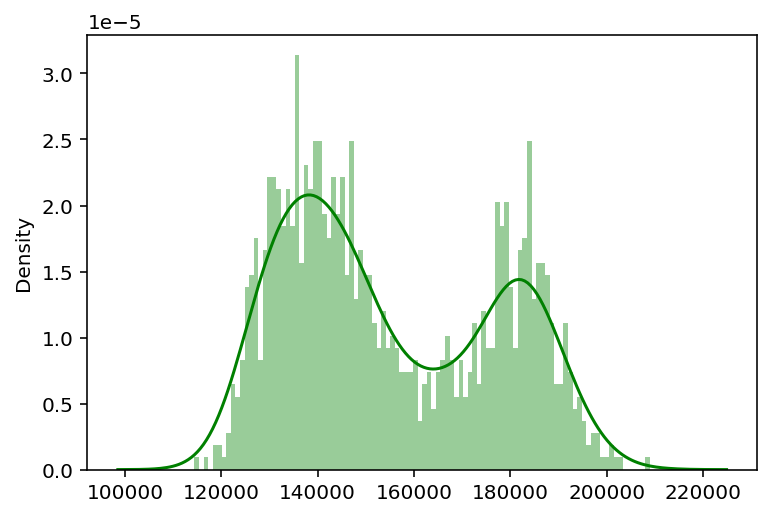

In [111]:
sns.distplot(final_results, color='g', bins=100, hist_kws={'alpha': 0.4})

In [112]:
df_submission = pd.read_csv('data/test.csv')
df_submission['SalePrice'] = df_results['SalePrice'].mean()
df_submission = df_submission[['Id', 'SalePrice']].merge(df_results,
                                         how='left',
                                         on='Id')

In [113]:
def adjust_SalePrice(row):
    if np.isnan(row['SalePrice_y']):
        return row['SalePrice_x']
    else:
        return row['SalePrice_y']

df_submission['SalePrice'] = df_submission.apply(adjust_SalePrice, axis=1)
df_submission

,Id,SalePrice_x,SalePrice_y,SalePrice
0,1461,155132.339169,137840.437500,137840.437500
1,1462,155132.339169,146768.453125,146768.453125
2,1463,155132.339169,164042.390625,164042.390625
3,1464,155132.339169,171048.203125,171048.203125
4,1465,155132.339169,169196.531250,169196.531250
...,...,...,...,...
1454,2915,155132.339169,NaN,155132.339169
1455,2916,155132.339169,132456.968750,132456.968750
1456,2917,155132.339169,147025.875000,147025.875000
1457,2918,155132.339169,NaN,155132.339169


In [114]:
df_submission.isna().mean()

Id             0.000000
SalePrice_x    0.000000
SalePrice_y    0.214531
SalePrice      0.000000
dtype: float64

In [115]:
df_submission[['Id', 'SalePrice']].to_csv('data/submission_1.csv', index=False)

# Competition Ranking

Score: 0.43868
Rank: 8211